In [1]:
# https://www.oreilly.com/library/view/machine-learning-for/9781449330514/
# https://github.com/johnmyleswhite/ML_for_Hackers

In [2]:
import numpy as np
import scipy as sp
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
file = './privacy/01_heights_weights_genders.csv'
df = pd.read_csv(file)
df['Height'] *= 2.54
df['Weight'] /= 2.204623

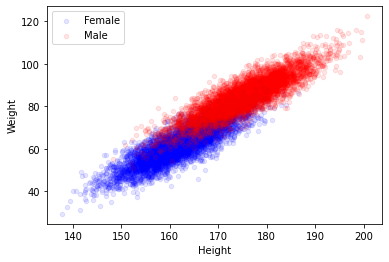

In [4]:
fig, ax = plt.subplots()
colors = {'Male':'red', 'Female':'blue'}

grouped = df.groupby('Gender')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='Height', y='Weight', 
               alpha=0.1,label=key, color=colors[key])

plt.show()

In [5]:
df.duplicated().any() # No duplicates. Everyone uniquely identifyable.

False

In [6]:
df.round(0).duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
9995     True
9996     True
9997     True
9998     True
9999     True
Length: 10000, dtype: bool

In [7]:
import sklearn as sk
from sklearn import mixture

n_components = 2
cv_type = 'full'
gmm = mixture.GaussianMixture(n_components=n_components,
                              covariance_type=cv_type,
                              means_init = [[90,185],[60,160]],
                              tol=0.0001,
                              reg_covar=1e-07,
                              max_iter=1000,
                              n_init=1)
gmm.fit(df.loc[:,['Weight','Height']])

GaussianMixture(max_iter=1000,
                means_init=array([[ 90., 185.],
       [ 60., 160.]]),
                n_components=2, reg_covar=1e-07, tol=0.0001)

In [8]:
samples = gmm.sample(10000)
X = samples[0]
y = samples[1]

In [9]:
Gender = np.where(y==0,'Male','Female')
Height = X[:,1]
Weight = X[:,0]
samples = pd.DataFrame([Gender,Height,Weight]).T
samples.columns = df.columns

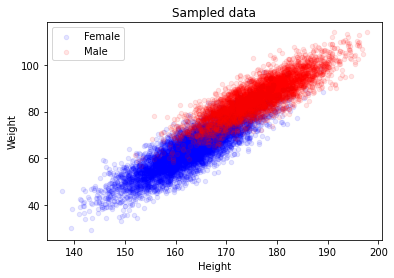

In [10]:
fig, ax = plt.subplots()
colors = {'Male':'red', 'Female':'blue'}

grouped = samples.groupby('Gender')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='Height', y='Weight', 
               alpha=0.1,label=key, color=colors[key])
plt.title('Sampled data')
plt.show()

### Bivariate conditional distribution of a multivariate Gaussian
$$\displaystyle X_{1}\mid X_{2}=a\ \sim \ {\mathcal {N}}\left(\mu _{1}+{\frac {\sigma _{1}}{\sigma _{2}}}\rho (a-\mu _{2}),\,(1-\rho ^{2})\sigma _{1}^{2}\right)$$

In [11]:
mus = gmm.means_
cvars = gmm.covariances_
mu = mus[0]
cvar = cvars[0]
mu, cvar

(array([ 86.15251266, 176.19622078]),
 array([[69.86997038, 48.96967801],
        [48.96967801, 47.75934721]]))

In [12]:
cvars

array([[[69.86997038, 48.96967801],
        [48.96967801, 47.75934721]],

       [[88.81326564, 57.92139321],
        [57.92139321, 51.24739721]]])

In [13]:
a = 160 # coniditioned on height at a
rho = cvar[0][1]/((cvar[0][0]**0.5)*(cvar[1][1]**0.5))
loc_ = mu[0] + (cvar[0][0]**0.5/cvar[1][1]**0.5)*rho*(a-mu[1])
scale_ = (1-rho**2)*cvar[0][0]
cond_weight_dist = stats.norm(loc=loc_,scale=scale_)

In [14]:
a = 100 # coniditioned on weight at a
rho = cvar[0][1]/((cvar[0][0]**0.5)*(cvar[1][1]**0.5))
loc_ = mu[1] + (cvar[1][1]**0.5/cvar[0][0]**0.5)*rho*(a-mu[0])
scale_ = (1-rho**2)*cvar[1][1]
cond_height_dist = stats.norm(loc=loc_,scale=scale_)

Text(0.5, 0, 'Height (cm)')

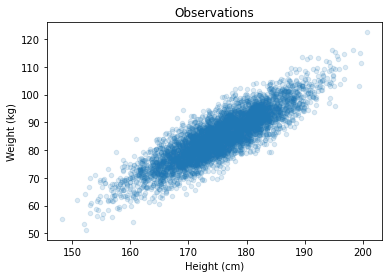

In [15]:
df.loc[df['Gender']=='Male'].plot.scatter('Height','Weight', alpha=0.15)
plt.title('Observations')
plt.ylabel('Weight (kg)')
plt.xlabel('Height (cm)')

In [16]:
n_components = 1
cv_type = 'full'
gmm_ = mixture.GaussianMixture(n_components=n_components,
                              covariance_type=cv_type,
                              means_init = [[90,185]],
                              tol=0.0001,
                              reg_covar=1e-07,
                              max_iter=1000,
                              n_init=1)
gmm_.fit(df.loc[df['Gender']=='Male',['Weight','Height']])

GaussianMixture(max_iter=1000, means_init=array([[ 90., 185.]]),
                reg_covar=1e-07, tol=0.0001)

In [17]:
cvars = gmm_.covariances_[0]
x = cvars[0][0]
cvars[0][0] = cvars[1][1]
cvars[1][1] = x

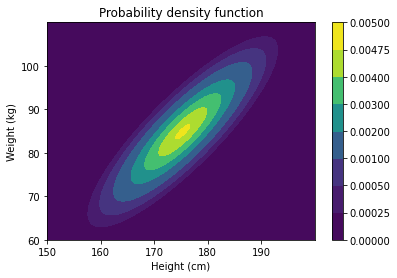

In [18]:
x, y = np.mgrid[150:200:.01, 60:110:.01]
# x, y = np.mgrid[130:200:0.1, 30:120:.1]
pos = np.dstack((x, y))
rv = stats.multivariate_normal(gmm_.means_[0][::-1],gmm_.covariances_[0])
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
cs = ax2.contourf(x, y, rv.pdf(pos), levels=[0,0.00025,0.0005,0.001,0.002,0.003,0.004,0.00475,0.005])
fig2.colorbar(cs)
plt.title('Probability density function')
plt.ylabel('Weight (kg)')
plt.xlabel('Height (cm)')
plt.show()

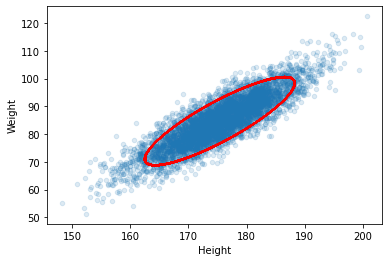

In [19]:
ll = rv.pdf(pos)
limits = pos[(ll<0.00101) & (ll>0.00099999)] # May use any thresholding on the pdf; should integrate patches
df_ = df.loc[df['Gender']=='Male',:].copy()
df_.plot.scatter('Height','Weight', alpha=0.15)
plt.scatter(limits[:,0],limits[:,1], c='red', s=0.1)

In [20]:
obs = df_.iloc[0:1,1:3]
#obs = np.array([180,82.5])
obs = np.array([187.5,95])
rv.pdf(obs)

0.0009840089102550848

In [21]:
def proba(obs,cm=1.25,kg=2.5):
    ''' Pseudo-integration; approximates well in a sufficiently small window.
    '''
    return (rv.pdf(obs + np.array([cm,kg])) + rv.pdf(obs + np.array([-cm,-kg])) + rv.pdf(obs + np.array([cm,-kg])) + rv.pdf(obs + np.array([-cm,kg])))/4
proba(obs)

0.0009289544623968507

To protect against an adversary, we require obfuscation for any improbable feature combination as such a revealed value can be mapped to an increasingly small number of individuals.
Assuming any individual has a unique height and weight if measured with sufficient precision, any area requires obfuscation. The degree of obfuscation required is the inverse probability density function $-$ very frequent values may be revealed with a higher degree of detail than rare values.

We present a step in both directions, we use a minimum threshold which each feature combination has to fulfill (akin to $Min-Entropy$) as well as coarsen the remaining observations to limit unintended leakage through excess precision (akin to $k-Anonymity$).

In [22]:
values = df_.loc[:,['Height','Weight']].values
limits_c = limits - gmm_.means_[0][::-1]
values_c = values - gmm_.means_[0][::-1]
limits_sq = (limits_c**2).sum(axis=1)
values_sq = (values_c**2).sum(axis=1) 

In [23]:
def bound_values(x):
    x = x.values
    ix = ((x - limits)**2).sum(axis=1).argmin()
    val_vec = ((x - gmm_.means_[0][::-1])**2).sum()
    lim_vec = ((limits[ix] - gmm_.means_[0][::-1])**2).sum()
    if val_vec > lim_vec:
        return limits[ix]
    else:
        return x
x = df_.loc[:,['Height','Weight']].iloc[0]
bound_values(x), x

(array([186.7 , 100.74]),
 Height    187.571423
 Weight    109.721056
 Name: 0, dtype: float64)

In [24]:
bounded_values = df_.loc[:,['Height','Weight']].apply(lambda x: bound_values(x), axis=1).values
bounded_values = np.vstack(bounded_values)

In [25]:
df_['p_Height'] = bounded_values[:,0]
df_['p_Weight'] = bounded_values[:,1]

Text(0.5, 1.0, 'Probability Thresholding')

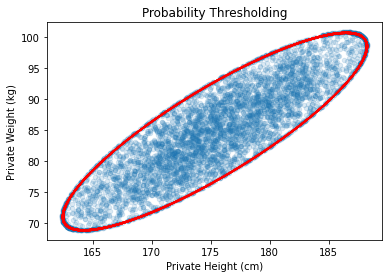

In [26]:
df_.plot.scatter('p_Height','p_Weight', alpha=0.15)
plt.scatter(limits[:,0],limits[:,1], c='red', s=0.1)
plt.xlabel('Private Height (cm)')
plt.ylabel('Private Weight (kg)')
plt.title('Probability Thresholding')

# Sufficiently rare, high entropy observations do not exist anymore; these would be `generally` identifiable
# Further, data is coarsened `within` boundaries to protect against too precise prior knowledge.

Text(0.5, 1.0, 'Precision Limitation')

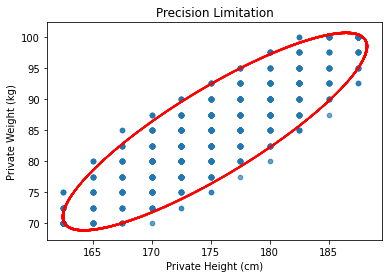

In [27]:
((df_.loc[:,['p_Height','p_Weight']]/2.5).round(0)*2.5).plot.scatter('p_Height','p_Weight', alpha=0.15)
plt.scatter(limits[:,0],limits[:,1], c='red', s=0.1)
plt.xlabel('Private Height (cm)')
plt.ylabel('Private Weight (kg)')
plt.title('Precision Limitation')

# Sufficiently rare, high entropy observations do not exist anymore; these would be `generally` identifiable
# Further, data is coarsened `within` boundaries to protect against too precise prior knowledge.

In [28]:
df__ = ((df_.loc[:,['p_Height','p_Weight']]/2.5).round(0)*2.5).groupby(['p_Height','p_Weight']).size().reset_index()
df__.columns = ['p_Height','p_Weight','count']
df__.loc[df__['count'] < 10]

,p_Height,p_Weight,count
15,170.0,70.0,7
39,177.5,77.5,6
47,180.0,80.0,7
62,185.0,87.5,6


In [29]:
df_.loc[:,['pp_Height','pp_Weight']] = ((df_.loc[:,['p_Height','p_Weight']]/2.5).round(0)*2.5).values
loc_ = [184,95]
scale_ = [[1.5,0],[0,1.5]]
norm = stats.multivariate_normal(loc_,scale_)

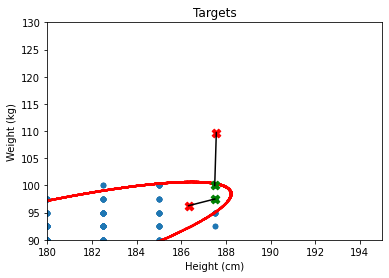

In [30]:
fig, ax = plt.subplots()

plt.plot(df_.loc[3266,['Height','pp_Height']], df_.loc[3266,['Weight','pp_Weight']],c='black')
plt.plot(df_.loc[0,['Height','pp_Height']], df_.loc[0,['Weight','pp_Weight']],c='black')

df_.iloc[1:].plot.scatter(ax=ax, x='pp_Height',y='pp_Weight', alpha=0.25)
ax.scatter(limits[:,0],limits[:,1],c='red',s=0.25,alpha=1)

df_.iloc[0:1].plot.scatter(ax=ax, x='Height',y='Weight', alpha=1,c='red',marker='X',s=75)
df_.iloc[0:1].plot.scatter(ax=ax, x='pp_Height',y='pp_Weight', alpha=1,c='green',marker='X',s=75)
df_.loc[3266:3266+1].plot.scatter(ax=ax, x='Height',y='Weight', alpha=1,c='red',marker='X',s=75)
df_.loc[3266:3266+1].plot.scatter(ax=ax, x='pp_Height',y='pp_Weight', alpha=1,c='green',marker='X',s=75)

plt.title('Targets')
plt.xlim([180,195])
plt.ylim([90,130])
plt.ylabel('Weight (kg)')
plt.xlabel('Height (cm)')
# ax.text(0.05, 0.95, 'Observation: 187cm, 109kg', transform=ax.transAxes, fontsize=14,
#         verticalalignment='top')
plt.show()

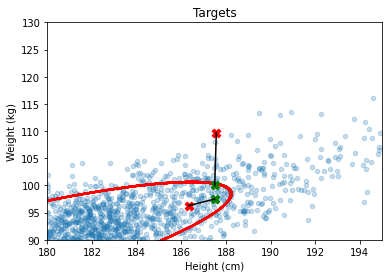

In [31]:
fig, ax = plt.subplots()

plt.plot(df_.loc[3266,['Height','pp_Height']], df_.loc[3266,['Weight','pp_Weight']],c='black')
plt.plot(df_.loc[0,['Height','pp_Height']], df_.loc[0,['Weight','pp_Weight']],c='black')

df_.iloc[1:].plot.scatter(ax=ax, x='Height',y='Weight', alpha=0.25)
ax.scatter(limits[:,0],limits[:,1],c='red',s=0.25,alpha=1)

df_.iloc[0:1].plot.scatter(ax=ax, x='Height',y='Weight', alpha=1,c='red',marker='X',s=75)
df_.iloc[0:1].plot.scatter(ax=ax, x='pp_Height',y='pp_Weight', alpha=1,c='green',marker='X',s=75)
df_.loc[3266:3266+1].plot.scatter(ax=ax, x='Height',y='Weight', alpha=1,c='red',marker='X',s=75)
df_.loc[3266:3266+1].plot.scatter(ax=ax, x='pp_Height',y='pp_Weight', alpha=1,c='green',marker='X',s=75)

plt.title('Targets')
plt.xlim([180,195])
plt.ylim([90,130])
plt.ylabel('Weight (kg)')
plt.xlabel('Height (cm)')
# ax.text(0.05, 0.95, 'Observation: 187cm, 109kg', transform=ax.transAxes, fontsize=14,
#         verticalalignment='top')
plt.show()

In [32]:
# Differential Privacy
sens = df_['Weight'].max()-df_['Weight'].min()
noise = stats.laplace.rvs(0,sens,size=5000)
df_['dp_Weight'] = df_['Weight']+noise

In [33]:
sens = df_['Height'].max()-df_['Height'].min()
noise = stats.laplace.rvs(0,sens,size=5000)
df_['dp_Height'] = df_['Height']+noise

Text(0.5, 1.0, 'Differentially private data')

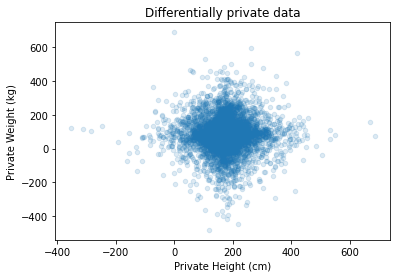

In [34]:
df_.plot.scatter('dp_Height','dp_Weight', alpha=0.15)
plt.xlabel('Private Height (cm)')
plt.ylabel('Private Weight (kg)')
plt.title('Differentially private data')

### Plotting

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


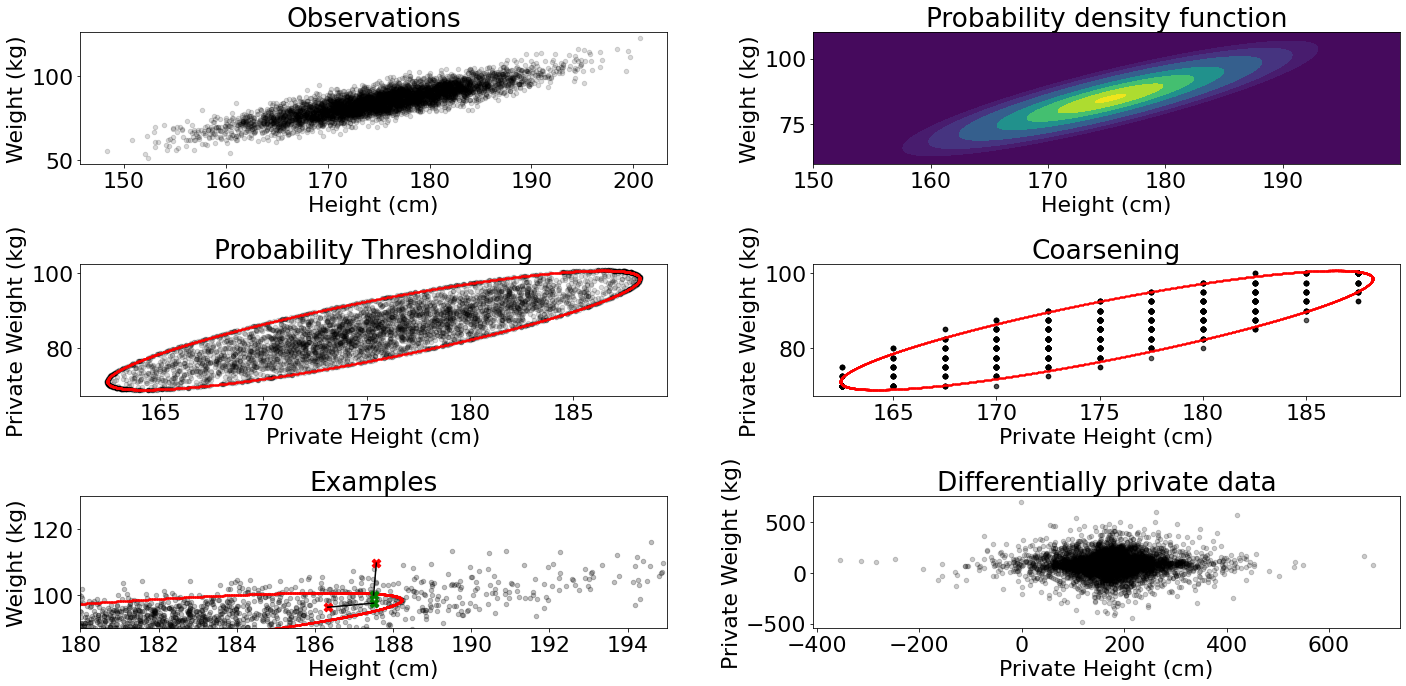

In [35]:
import matplotlib
plt.rcParams["figure.figsize"] = (20,10)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)

fig, ax = plt.subplots(3,2)

i,j = 0,0
df_.plot.scatter(x='Height',y='Weight', ax=ax[i][j], alpha=0.15, c='black')
ax[i][j].set_xlabel('Height (cm)')
ax[i][j].set_ylabel('Weight (kg)')
ax[i][j].set_title('Observations')

i,j = 0,1
x, y = np.mgrid[150:200:.01, 60:110:.01]
# x, y = np.mgrid[130:200:0.1, 30:120:.1]
pos = np.dstack((x, y))
ax[i][j].contourf(x, y, rv.pdf(pos), levels=[0,0.00025,0.0005,0.001,0.002,0.003,0.004,0.00475,0.005])
#ax[i][j].colorbar()
ax[i][j].set_title('Probability density function')
ax[i][j].set_ylabel('Weight (kg)')
ax[i][j].set_xlabel('Height (cm)')


i,j = 1,0
df_.plot.scatter(x='p_Height',y='p_Weight', ax=ax[i][j], alpha=0.15, c='black')
ax[i][j].scatter(limits[:,0],limits[:,1], c='red', s=0.1)
ax[i][j].set_xlabel('Private Height (cm)')
ax[i][j].set_ylabel('Private Weight (kg)')
ax[i][j].set_title('Probability Thresholding')

i,j = 1,1
df_.plot.scatter(x='pp_Height',y='pp_Weight', ax=ax[i][j], alpha=0.15, c='black')
ax[i][j].scatter(limits[:,0],limits[:,1], c='red', s=0.1)
ax[i][j].set_xlabel('Private Height (cm)')
ax[i][j].set_ylabel('Private Weight (kg)')
ax[i][j].set_title('Coarsening')

i,j = 2,0
ax[i][j].plot(df_.loc[3266,['Height','pp_Height']], df_.loc[3266,['Weight','pp_Weight']],c='black')
ax[i][j].plot(df_.loc[0,['Height','pp_Height']], df_.loc[0,['Weight','pp_Weight']],c='black')

df_.iloc[1:].plot.scatter(ax=ax[i][j], x='Height',y='Weight', alpha=0.25,c='black')
ax[i][j].scatter(limits[:,0],limits[:,1],c='red',s=0.25,alpha=1)

df_.iloc[0:1].plot.scatter(ax=ax[i][j], x='Height',y='Weight', alpha=1,c='red',marker='X',s=75)
df_.iloc[0:1].plot.scatter(ax=ax[i][j], x='pp_Height',y='pp_Weight', alpha=1,c='green',marker='X',s=75)
df_.loc[3266:3266+1].plot.scatter(ax=ax[i][j], x='Height',y='Weight', alpha=1,c='red',marker='X',s=75)
df_.loc[3266:3266+1].plot.scatter(ax=ax[i][j], x='pp_Height',y='pp_Weight', alpha=1,c='green',marker='X',s=75)

ax[i][j].set_title('Examples')
ax[i][j].set_xlim([180,195])
ax[i][j].set_ylim([90,130])
ax[i][j].set_ylabel('Weight (kg)')
ax[i][j].set_xlabel('Height (cm)')
# ax.text(0.05, 0.95, 'Observation: 187cm, 109kg', transform=ax.transAxes, fontsize=14,
#         verticalalignment='top')


i,j = 2,1
df_.plot.scatter(ax=ax[i][j],x='dp_Height',y='dp_Weight', alpha=0.2, c='black')
ax[i][j].set_xlabel('Private Height (cm)')
ax[i][j].set_ylabel('Private Weight (kg)')
ax[i][j].set_title('Differentially private data')
# i,j = 1,1
# ax[i][j].plot(df_.loc[3266,['Height','pp_Height']], df_.loc[3266,['Weight','pp_Weight']],c='black')
# ax[i][j].plot(df_.loc[0,['Height','pp_Height']], df_.loc[0,['Weight','pp_Weight']],c='black')

# df_.iloc[1:].plot.scatter(ax=ax[i][j], x='Height',y='Weight', alpha=0.25)
# ax[i][j].scatter(limits[:,0],limits[:,1],c='red',s=0.25,alpha=1)

# df_.iloc[0:1].plot.scatter(ax=ax[i][j], x='Height',y='Weight', alpha=1,c='red',marker='X',s=75)
# df_.iloc[0:1].plot.scatter(ax=ax[i][j], x='pp_Height',y='pp_Weight', alpha=1,c='green',marker='X',s=75)
# df_.loc[3266:3266+1].plot.scatter(ax=ax[i][j], x='Height',y='Weight', alpha=1,c='red',marker='X',s=75)
# df_.loc[3266:3266+1].plot.scatter(ax=ax[i][j], x='pp_Height',y='pp_Weight', alpha=1,c='green',marker='X',s=75)

# ax[i][j].set_title('Samples')
# ax[i][j].set_xlim([180,195])
# ax[i][j].set_ylim([90,130])
# ax[i][j].set_ylabel('Weight (kg)')
# ax[i][j].set_xlabel('Height (cm)')
# ax.text(0.05, 0.95, 'Observation: 187cm, 109kg', transform=ax.transAxes, fontsize=14,
#         verticalalignment='top')
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
fig.savefig('./fig/example.png')
plt.show()

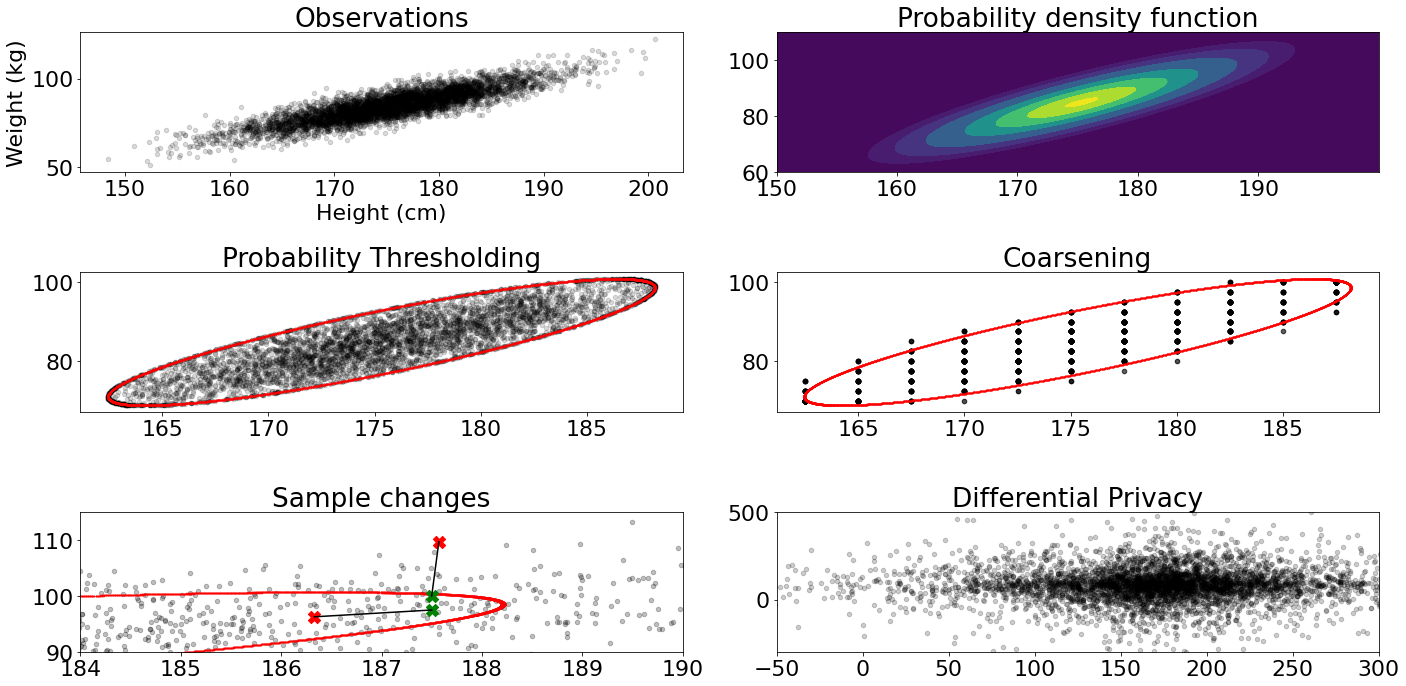

In [36]:
import matplotlib
plt.rcParams["figure.figsize"] = (20,10)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)

fig, ax = plt.subplots(3,2)

i,j = 0,0
df_.plot.scatter(x='Height',y='Weight', ax=ax[i][j], alpha=0.15, c='black')
ax[i][j].set_xlabel('Height (cm)')
ax[i][j].set_ylabel('Weight (kg)')
ax[i][j].set_title('Observations')

i,j = 0,1
x, y = np.mgrid[150:200:.01, 60:110:.01]
# x, y = np.mgrid[130:200:0.1, 30:120:.1]
pos = np.dstack((x, y))
ax[i][j].contourf(x, y, rv.pdf(pos), levels=[0,0.00025,0.0005,0.001,0.002,0.003,0.004,0.00475,0.005])
#ax[i][j].colorbar()
ax[i][j].set_title('Probability density function')
ax[i][j].set_ylabel('')
ax[i][j].set_xlabel('')


i,j = 1,0
df_.plot.scatter(x='p_Height',y='p_Weight', ax=ax[i][j], alpha=0.15, c='black')
ax[i][j].scatter(limits[:,0],limits[:,1], c='red', s=0.1)
ax[i][j].set_xlabel('')
ax[i][j].set_ylabel('')
ax[i][j].set_title('Probability Thresholding')

i,j = 1,1
df_.plot.scatter(x='pp_Height',y='pp_Weight', ax=ax[i][j], alpha=0.15, c='black')
ax[i][j].scatter(limits[:,0],limits[:,1], c='red', s=0.1)
ax[i][j].set_xlabel('')
ax[i][j].set_ylabel('')
ax[i][j].set_title('Coarsening')

i,j = 2,0
ax[i][j].plot(df_.loc[3266,['Height','pp_Height']], df_.loc[3266,['Weight','pp_Weight']],c='black')
ax[i][j].plot(df_.loc[0,['Height','pp_Height']], df_.loc[0,['Weight','pp_Weight']],c='black')

df_.iloc[1:].plot.scatter(ax=ax[i][j], x='Height',y='Weight', alpha=0.25,c='black')
ax[i][j].scatter(limits[:,0],limits[:,1],c='red',s=0.25,alpha=1)

df_.iloc[0:1].plot.scatter(ax=ax[i][j], x='Height',y='Weight', alpha=1,c='red',marker='X',s=150)
df_.iloc[0:1].plot.scatter(ax=ax[i][j], x='pp_Height',y='pp_Weight', alpha=1,c='green',marker='X',s=150)
df_.loc[3266:3266+1].plot.scatter(ax=ax[i][j], x='Height',y='Weight', alpha=1,c='red',marker='X',s=150)
df_.loc[3266:3266+1].plot.scatter(ax=ax[i][j], x='pp_Height',y='pp_Weight', alpha=1,c='green',marker='X',s=150)

ax[i][j].set_title('Sample changes')
ax[i][j].set_xlim([184,190])
ax[i][j].set_ylim([90,115])
ax[i][j].set_ylabel('')
ax[i][j].set_xlabel('')
# ax.text(0.05, 0.95, 'Observation: 187cm, 109kg', transform=ax.transAxes, fontsize=14,
#         verticalalignment='top')


i,j = 2,1
df_.plot.scatter(ax=ax[i][j],x='dp_Height',y='dp_Weight', alpha=0.2, c='black')
ax[i][j].set_xlabel('')
ax[i][j].set_ylabel('')
ax[i][j].set_xlim([-50,300])
ax[i][j].set_ylim([-300,500])
ax[i][j].set_title('Differential Privacy')
# i,j = 1,1
# ax[i][j].plot(df_.loc[3266,['Height','pp_Height']], df_.loc[3266,['Weight','pp_Weight']],c='black')
# ax[i][j].plot(df_.loc[0,['Height','pp_Height']], df_.loc[0,['Weight','pp_Weight']],c='black')

# df_.iloc[1:].plot.scatter(ax=ax[i][j], x='Height',y='Weight', alpha=0.25)
# ax[i][j].scatter(limits[:,0],limits[:,1],c='red',s=0.25,alpha=1)

# df_.iloc[0:1].plot.scatter(ax=ax[i][j], x='Height',y='Weight', alpha=1,c='red',marker='X',s=75)
# df_.iloc[0:1].plot.scatter(ax=ax[i][j], x='pp_Height',y='pp_Weight', alpha=1,c='green',marker='X',s=75)
# df_.loc[3266:3266+1].plot.scatter(ax=ax[i][j], x='Height',y='Weight', alpha=1,c='red',marker='X',s=75)
# df_.loc[3266:3266+1].plot.scatter(ax=ax[i][j], x='pp_Height',y='pp_Weight', alpha=1,c='green',marker='X',s=75)

# ax[i][j].set_title('Samples')
# ax[i][j].set_xlim([180,195])
# ax[i][j].set_ylim([90,130])
# ax[i][j].set_ylabel('Weight (kg)')
# ax[i][j].set_xlabel('Height (cm)')
# ax.text(0.05, 0.95, 'Observation: 187cm, 109kg', transform=ax.transAxes, fontsize=14,
#         verticalalignment='top')
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
fig.savefig('./fig/example.png')
plt.show()